# 🚗 Path Planning – Interpolating Discrete Points

This is where the actual task of **planning a path** begins.

In the real world, we rarely have access to a **continuous set of paths**.  
Instead, we deal with a **limited number of discrete points**, such as waypoints from cone detections or sensor outputs.

Our job is to **connect these discrete points** and generate a smooth and feasible trajectory that the vehicle can follow.

---

## Why Do We Need Interpolation?

Since we cannot drive through isolated points, we must **"connect the dots"** to create a **continuous path**.  
There are different methods for this, and choosing the right one depends on the trade-offs between:
- Accuracy
- Smoothness
- Computation time
- Real-time feasibility

You are encouraged to **explore** these topics online and understand them deeply.  
Your final goal is to **optimize the path**, so analyze each method’s **advantages and disadvantages**.

---

## Suggested Resources

### A) Linear and Quadratic Spline Interpolation
- [Linear & Quadratic Spline Intuition](https://www.youtube.com/watch?v=KLUr1A6vyzs)
- [Quadratic Interpolation Explanation](https://www.youtube.com/watch?v=j_jBK7zJ1vU)
- [Quadratic Spline Derivation](https://www.youtube.com/watch?v=kCPMph3cPA8)

### B) Cubic and Higher-Degree Spline Interpolation
- [Cubic Spline Derivation](https://www.youtube.com/watch?v=wMMjF7kXnWA)
- [Cubic Spline Example](https://www.youtube.com/watch?v=gT7F3TWihvk)

> Try solving the example problem yourself before watching the solution.  
> Now imagine scaling that to **hundreds of points** in real-time path planning!

---

## Assignment

## You are given **four discrete points** in increasing order of x:  
`(x₁, y₁), (x₂, y₂), (x₃, y₃), (x₄, y₄)`

Your task is to:
- **Interpolate these points using Cubic Spline Interpolation**
- **Plot the path obtained.**
- **Do NOT use direct library interpolation functions**
    - You can look up source code online for understanding.
    - But make sure you know **exactly what the code is doing**, step by step.

---

## What to Submit

- Your coded solution (with explanation)
- Analysis of cubic splines vs other interpolation methods
    - Think about smoothness, accuracy, computational cost, and usability in real-time systems

Happy Coding & Exploring!

## 🌟 Optional Assignment

Once you're done with the 4-point cubic spline:

Try writing your **own generic cubic spline interpolation** code for **any number of points (n ≥ 4) taken as input**.

- Again, **do not use `scipy`, `numpy.interp`, or any built-in spline functions**.
- Construct and solve the system of equations manually (or using matrix operations) based on the cubic spline conditions.

This will give you an appreciation of the complexity behind interpolation libraries — and how they are optimized.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
def cubic_spline_generator(x,y):
    n = 3  # number of intervals
    h = [x[i+1] - x[i] for i in range(n)]
    
    # Setup the system for c[1] to c[n-1] 
    A = [0]*(n-1)  # sub-diagonal (A_1,...,A_{n-2})
    B = [0]*(n-1)  # main diagonal (B_1,...,B_{n-1})
    C = [0]*(n-1)  # super-diagonal (C_1,...,C_{n-2})
    D = [0]*(n-1)  # right-hand side

    for i in range(1, n):
        if i-1 >= 0:
            A[i-1] = h[i-1]
        B[i-1] = 2 * (h[i-1] + h[i])
        if i < n-1:
            C[i-1] = h[i]
        D[i-1] = 3 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1])
    
    # Solving the tridiagonal system for c[1] ... c[n-1] using Thomas algorithm
    c = [0] * (n + 1)  
    # Modifying the coefficients
    Cp = [0]*(n-1)
    Dp = [0]*(n-1)
    Cp[0] = C[0] / B[0]
    Dp[0] = D[0] / B[0]
    for i in range(1, n-1):
        denom = B[i] - A[i] * Cp[i-1]
        Cp[i] = C[i] / denom
        Dp[i] = (D[i] - A[i] * Dp[i-1]) / denom

    # Back substitution
    c[n-1] = Dp[-1]
    for i in range(n-3, -1, -1):
        c[i+1] = Dp[i] - Cp[i] * c[i+2]

    # Compute spline coefficients for each interval
    a = [y[i] for i in range(n)]
    b = [0]*n
    d = [0]*n
    for i in range(n):
        b[i] = (y[i+1] - y[i]) / h[i] - h[i] * (2*c[i] + c[i+1]) / 3
        d[i] = (c[i+1] - c[i]) / (3 * h[i])

    # S_i(x) = a_i + b_i*(x - x_i) + c_i*(x - x_i)^2 + d_i*(x - x_i)^3 for x in [x_i, x_{i+1}]
    return a, b, c[:-1], d  # note: c has n+1 elements; we return c[0] to c[n-1] for intervals

if __name__ == "__main__":
    # data points initialisation
    x=np.array([1,2,4,7])
    y=np.array([2,4,5,4])
    a, b, c, d = cubic_spline_generator(x, y)

    # printing the final equations
    for i in range(3):
        print(f"Interval [{x[i]}, {x[i+1]}]:")
        print(f"   S_{i}(x) = {a[i]} + {b[i]}*(x - {x[i]}) + {c[i]}*(x - {x[i]})^2 + {d[i]}*(x - {x[i]})^3")


Interval [1, 2]:
   S_0(x) = 2 + 2.238095238095238*(x - 1) + 0*(x - 1)^2 + -0.2380952380952381*(x - 1)^3
Interval [2, 4]:
   S_1(x) = 4 + 1.523809523809524*(x - 2) + -0.7142857142857143*(x - 2)^2 + 0.1011904761904762*(x - 2)^3
Interval [4, 7]:
   S_2(x) = 5 + -0.11904761904761904*(x - 4) + -0.10714285714285714*(x - 4)^2 + 0.011904761904761904*(x - 4)^3


In [13]:
def evaluate_spline(x_points, a, b, c, d, x_eval):
    x_eval = np.array(x_eval)
    y_eval = np.array(x_eval)
    
    # Evaluate the spline for each x value
    for j, x_val in enumerate(x_eval):
        # Find the correct interval for x_val
        # If x_val is exactly the last x, use the last interval
        if x_val == x_points[-1]:
            i = len(x_points) - 2
        else:
            for i in range(len(x_points)-1):
                if x_points[i] <= x_val < x_points[i+1]:
                    break
        dx = x_val - x_points[i]
        y_eval[j] = a[i] + b[i]*dx + c[i]*dx**2 + d[i]*dx**3
    return y_eval

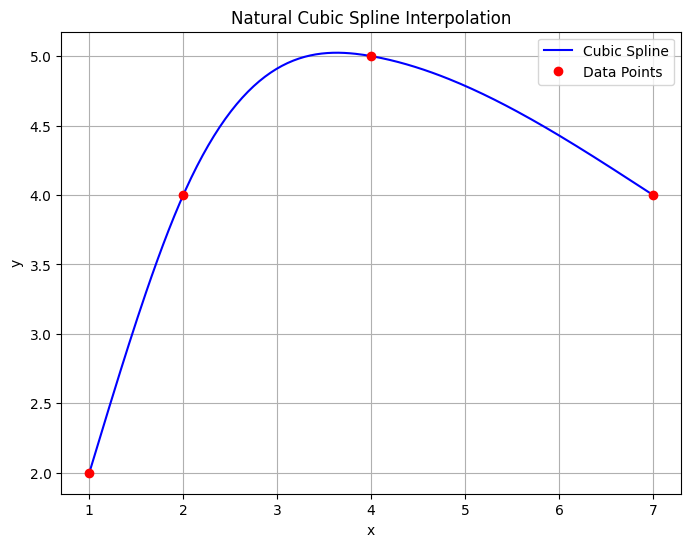

In [14]:
xs = np.linspace(x[0], x[-1], 200) #generates array of 200 points between x[0] and x[-1]
ys = evaluate_spline(x, a, b, c, d, xs)
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, label="Cubic Spline", color="blue")
plt.plot(x, y, "ro", label="Data Points")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Natural Cubic Spline Interpolation")
plt.legend()
plt.grid(True)
plt.show()